# Выявление закономерностей, влияющих на успешность видеоигр

## Цель исследования:
Выявить закономерности, влияющие на успешность игр. 
Определить потенциально успешный продукт, на основании чего дать рекомендации о проведении рекламных команий. 

## Ход исследования:
Обзор данных

Подготовка данных

Исследовательский анализ данных

Составление портрета пользователей каждого региона

Проверка гипотез

In [1]:
#импортируем необходимые для исследования библиотеки: pandas, matplotlib, seaborn, scipy, numpy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
import numpy as np

In [2]:
# читаем csv-файл
data = pd.read_csv('/datasets/games.csv')

## Подготовка данных

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


###  Обработка названий столбцов

In [4]:
# Приводим названия столбцов к нижнему регистру
data.columns = data.columns.str.lower()

In [5]:
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


###  Изменение типов данных
Изменение типов данных необходимо провести в следующих столбцах: year_of_release и user_score.
Изменение типов данных возможно только после обработки пустых строк. 

### Обработка пропусков

In [6]:
 # посчитаем количество пропущенных значений для каждого столбца
print(data.isna().sum())

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64


In [7]:
# для дальнейшего принятия решения об обработке пропусков определим долю пропущенных значений в столбце
pd.DataFrame(round(data.isna().mean()*100,1)).style.background_gradient('coolwarm')

,0
name,0.000000
platform,0.000000
year_of_release,1.600000
genre,0.000000
na_sales,0.000000
eu_sales,0.000000
jp_sales,0.000000
other_sales,0.000000
critic_score,51.300000
user_score,40.100000


Обнаружены пропуски в следующих столбцах: year_of_release, critic_score, user_score, rating.
Доля пропусков в столбце year_of_release незначительная, поэтому принято решение пропуски в данном столбце удалить. 
Пропуски в других столбцах удалить будет некорректно, так как они занимают большую долю. Заменять их медианным значением также некорректно, так как оценки, и критиков и пользователей, а также рейтинг для каждой конкретной игры могут сильно отличаться от медианного значения. 
Пропуски в столбцах critic_score решено оставить без изменений. 
Пропуски в столбце rating заполнены значением unknown.

В столбце user_score также встречается значение 'tbd', что означает 'to be determined'- в настоящее время оценки не определена, возможно, данные добавятся позже. В настоящее время принято решение значения 'tbd' заменить на np.nan.


In [8]:
# удаляем пропуски в столбце year_of_release
data = data.dropna(subset=['year_of_release'])

In [9]:
# обработка значений 'tbd'
data['user_score'] = data['user_score'].replace ('tbd', np.nan)

In [10]:
# обработка пропусков в столбце rating
data['rating'] = data['rating']. fillna('Unknown')

Причины, которые могли привести к пропускам: не всегда пользователи ставят оценки, не все игры оценены критиками и прошли оценку ESRB.
Также могли возникнуть технические ошибки при выгрузке данных. 

### Изменение типов данных (продолжение)

In [11]:
data['year_of_release'] = data['year_of_release'].astype('int')

In [12]:
data['user_score'] = data['user_score'].astype('float')

### Суммарные продажи во всех регионах

In [13]:
data['sales_total'] = data['na_sales']+data['eu_sales']+data['jp_sales']+data['other_sales']

### Обработка дубликатов

In [14]:
# поиск явных дубликатов
data.duplicated().sum()

0

##  Исследовательский анализ данных

### Количество игр, выпускавшееся в разные годы

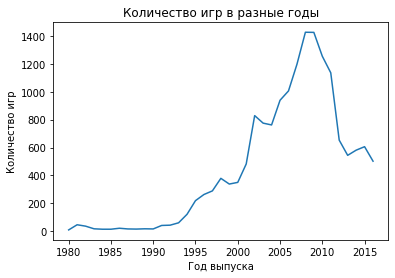

In [15]:
games_per_year = data.pivot_table (index='year_of_release', values='name', aggfunc='count').plot(legend=False,)
plt.title ('Количество игр в разные годы')
plt.ylabel ('Количество игр')
plt.xlabel ('Год выпуска');

После 2000 года количество выпускавшихся игр значительно больше, чем до,  с пиковыми значениями 2008-2010 гг. 

### Изменение продаж по платформам

In [16]:
# определим платформы с наибольшими продажами (топ 10)
sales_per_platform_max = data.pivot_table(index= 'platform', values='sales_total', aggfunc='sum').sort_values(by='sales_total', ascending=False).head(10)
display (sales_per_platform_max)

,sales_total
platform,
PS2,1233.56
X360,961.24
PS3,931.34
Wii,891.18
DS,802.78
PS,727.58
PS4,314.14
GBA,312.88
PSP,289.53


In [17]:
# выведем имена платформ с наибольшими суммарными продажами
top_pl = sales_per_platform_max .index
print(top_pl)

Index(['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS', 'PS4', 'GBA', 'PSP', '3DS'], dtype='object', name='platform')


In [18]:
# проведём фильтрацию датасета по платформам с наибольшими суммарными продажами
games = data[data['platform'].isin(top_pl)]

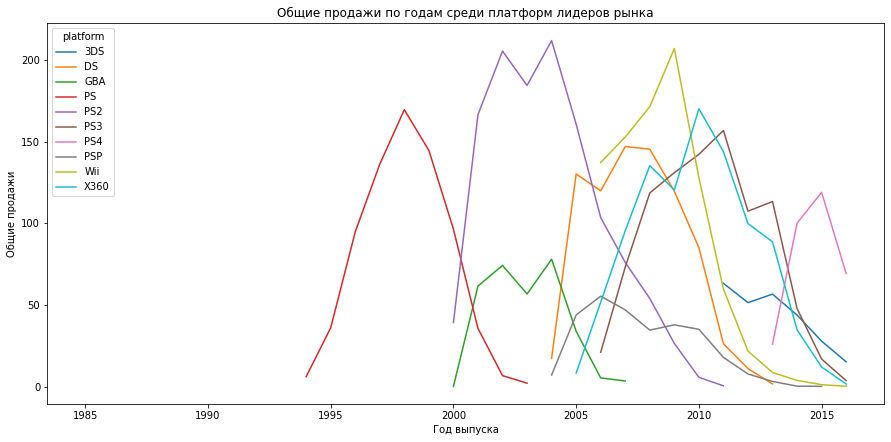

In [19]:
# построим график, на котором отображены продажи по годам среди платформ с наибольшими суммарными продажами
games .pivot_table(index = 'year_of_release', columns = 'platform', aggfunc = 'sum', values = 'sales_total').plot(figsize = (15,7));
plt.title ('Общие продажи по годам среди платформ лидеров рынка')
plt.ylabel ('Общие продажи')
plt.xlabel ('Год выпуска');

На графике видно, что в среднем одна платформа активна в течение 5-10 лет, затем происходит замена на новую платформу.

###  Определение актуального периода

Для дальнейшего исследования принято решение определить актульный период как 2014-2016 гг.

### Определение нескольких потенциально прибыльных платформ

In [20]:
# определим общие продажи платформ для актуального периода (2014-2016 гг)
platforms_actual = data.query('year_of_release>=2014').pivot_table(index='platform', values='sales_total', aggfunc='sum').sort_values(by='sales_total', ascending=False)
display(platforms_actual)

,sales_total
platform,
PS4,288.15
XOne,140.36
3DS,86.68
PS3,68.18
X360,48.22
WiiU,42.98
PC,27.05
PSV,22.40
Wii,5.07


In [21]:
# выведем имена платформ изучаемого актуального периода
actual_pl = platforms_actual .index
print(actual_pl)

Index(['PS4', 'XOne', '3DS', 'PS3', 'X360', 'WiiU', 'PC', 'PSV', 'Wii', 'PSP'], dtype='object', name='platform')


In [22]:
# проведём последовательную фильтрацию датасета по платформам для актуального периода
data_actual_pre= data[data['platform'].isin(actual_pl)]
data_actual=data_actual_pre.query('year_of_release>=2014')

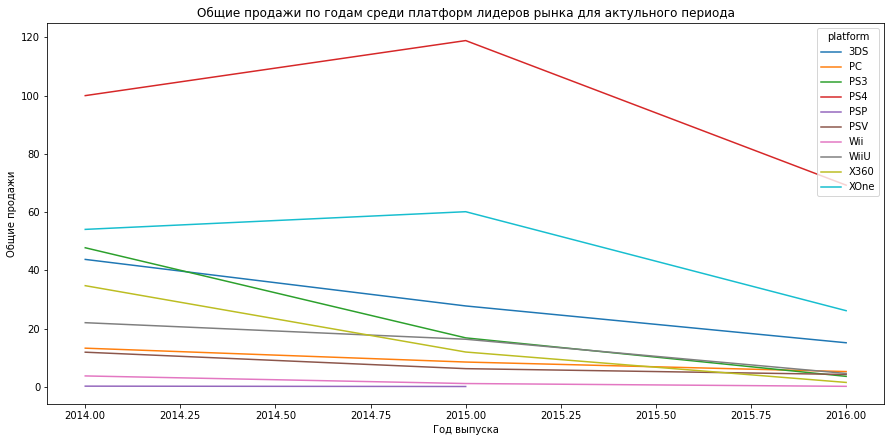

In [23]:
# построим график, на котором отображены продажи по годам среди платформ с наибольшими суммарными продажами
data_actual .pivot_table(index = 'year_of_release', columns = 'platform', aggfunc = 'sum', values = 'sales_total').plot(figsize = (15,7));
plt.title ('Общие продажи по годам среди платформ лидеров рынка для актульного периода')
plt.ylabel ('Общие продажи')
plt.xlabel ('Год выпуска');



Изучив данные за актуальный период мы видим, что платформы с наибольшими общими продажами в начале изучаемого периода (Wii, X360, PS3) к 2016 году становятся практически не актуальны. 

К потенциально прибыльным платформам можно отнести PS4 и XOne.

### Глобальные продажи по платформам

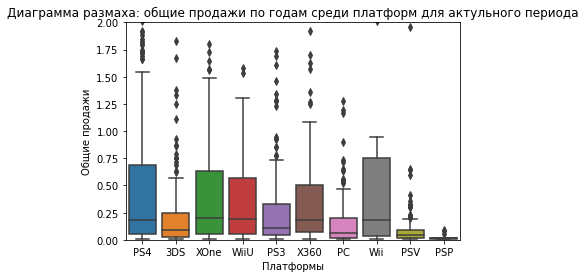

In [24]:
sns.boxplot(data = data_actual, x = 'platform', y = 'sales_total');
plt.ylim(0, 2)
plt.title ('Диаграмма размаха: общие продажи по годам среди платформ для актульного периода')
plt.ylabel ('Общие продажи')
plt.xlabel ('Платформы');


На графике мы видим, что как по общим продажам, так и по их медианным значениям лидируют платформы X360, PS4, XOne, WiiU, Wii.

###  Корреляция между отзывами (критиков и игроков) и общими продажами для лидера рынка (PS4) изучаемого периода

In [25]:
# проведём срез данных для одной из лидирующих платформ изучаемого периода
data_actual_for_ps4= data_actual.query('platform == "PS4"')

In [26]:
# посчитаем коэффициент Пирсона с целью определения зависимости между оценками критиков и общими продажами
print('Оценка критиков-общие продажи', data_actual_for_ps4.loc[~data_actual_for_ps4['critic_score'].isnull(), 'sales_total'].corr(data_actual_for_ps4.loc[~data_actual_for_ps4['critic_score'].isnull(), 'critic_score']))


Оценка критиков-общие продажи 0.40266141068104083


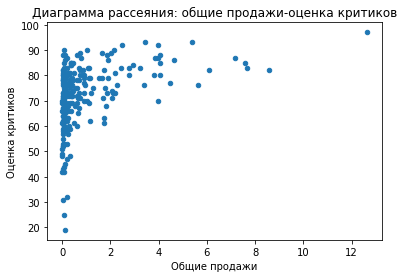

In [27]:
# визуализируем полученные данные
data_actual_for_ps4.plot(x='sales_total', y='critic_score', kind='scatter')
plt.title ('Диаграмма рассеяния: общие продажи-оценка критиков')
plt.ylabel ('Оценка критиков')
plt.xlabel ('Общие продажи');

In [28]:
# оценка корреляции между оценкой игроков и общими продажами
print('Оценка игроков-общие продажи', data_actual_for_ps4.loc[~data_actual_for_ps4['user_score'].isnull(), 'sales_total'].corr(data_actual_for_ps4.loc[~data_actual_for_ps4['user_score'].isnull(), 'user_score']))

Оценка игроков-общие продажи -0.040131589472697356


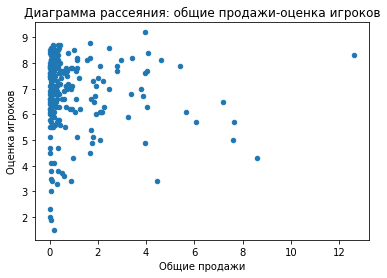

In [29]:
data_actual_for_ps4.plot(x='sales_total', y='user_score', kind='scatter')
plt.title ('Диаграмма рассеяния: общие продажи-оценка игроков')
plt.ylabel ('Оценка игроков')
plt.xlabel ('Общие продажи');

Изучив данные о корреляции между оценками критиков и игроков и общими продажами для одной из платформ (PS3) выяснили, что значимой зависимости между оценками и продажами нет, однако на общие продажи оценки критиков влияют больше, чем оценки игроков (положительная корреляция выражена сильнее-коэффициент Пирсона ближе к 1). 

### Оценка корреляции для других платформ

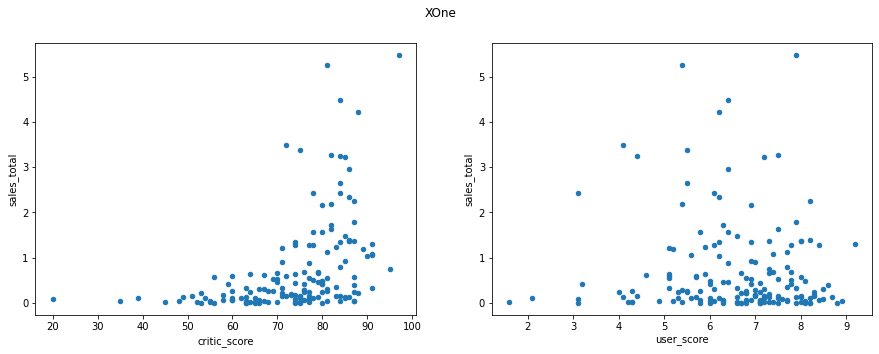

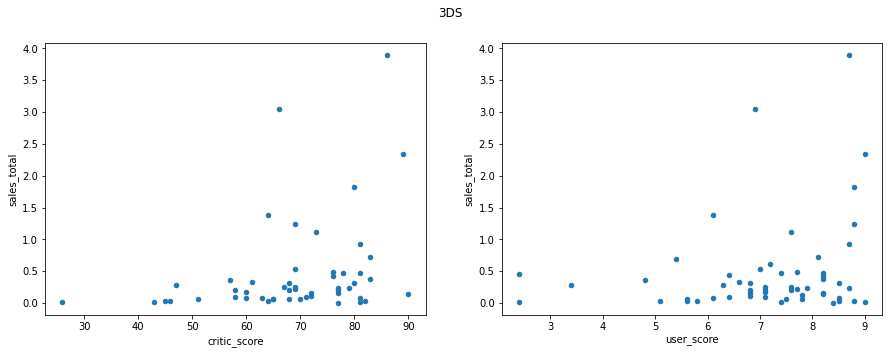

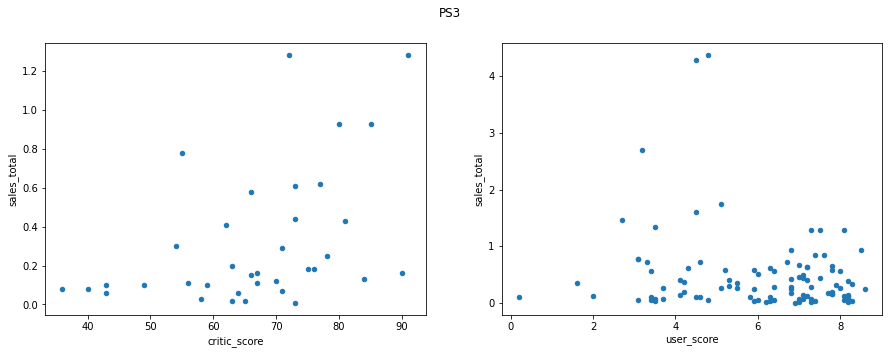

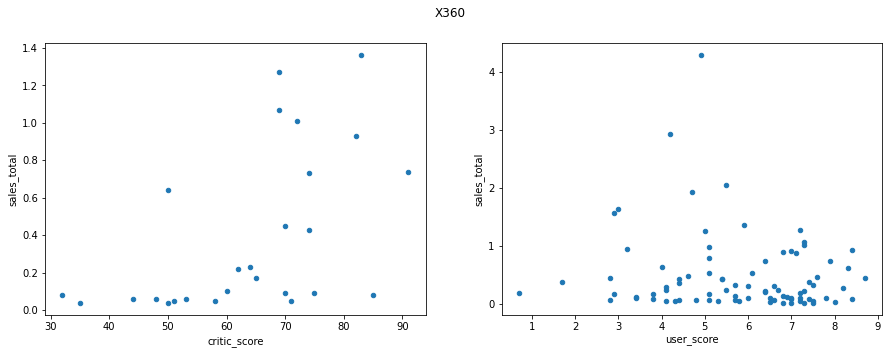

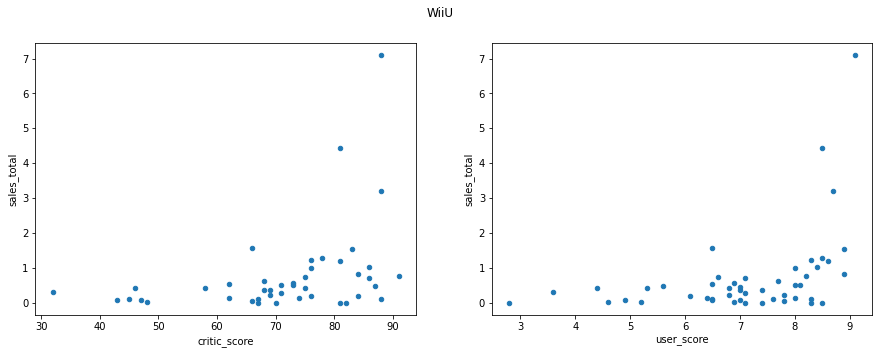

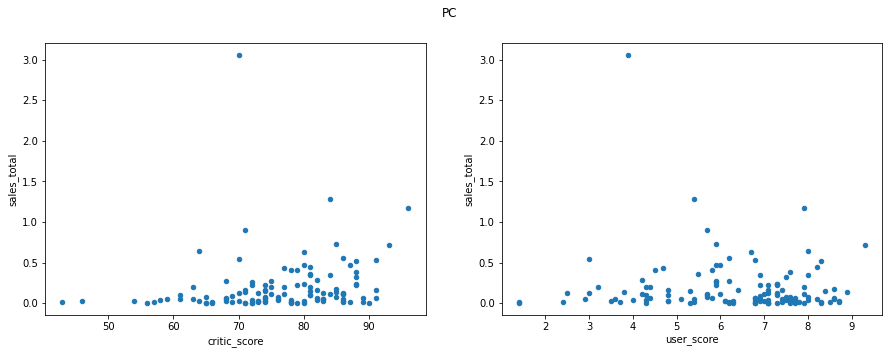

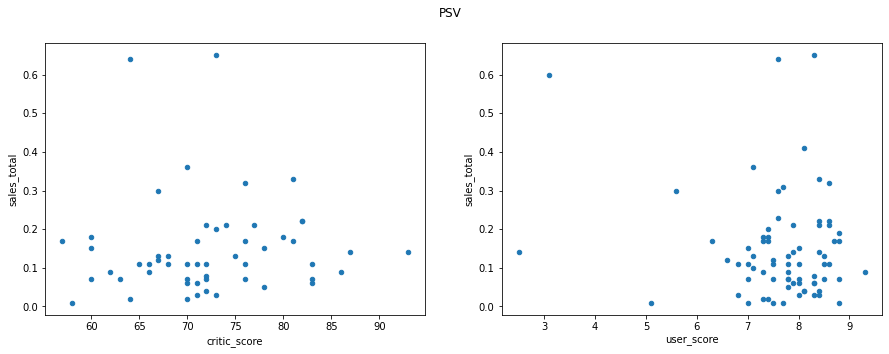

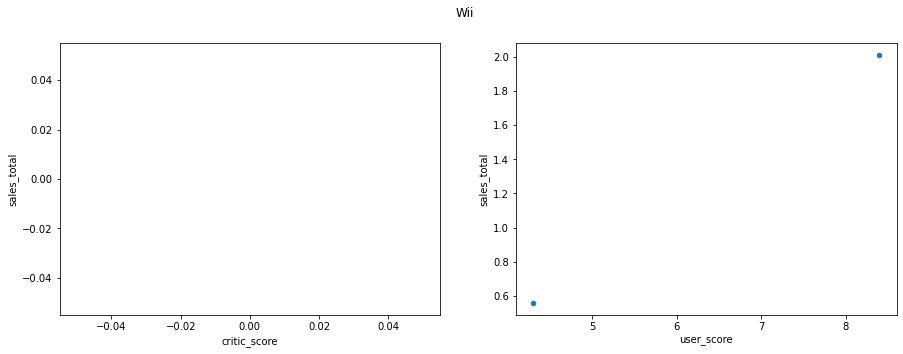

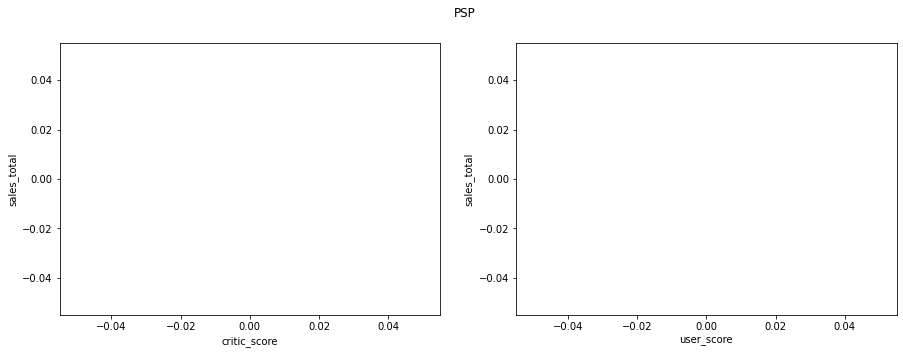

In [30]:
for pl in ['XOne', '3DS', 'PS3', 'X360', 'WiiU', 'PC', 'PSV', 'Wii', 'PSP']:
    fig, ax = plt.subplots(1,2, figsize = (15,5))
    ax = ax.ravel()
    data_actual.query('platform == @pl').plot(kind='scatter', x='critic_score', y='sales_total', ax = ax[0])
    data_actual.query('user_score != "tbd" and user_score != -10 and platform == @pl').plot(kind='scatter', x='user_score', y='sales_total', ax = ax[1])
    fig.suptitle(pl)

На представленных графиках также можно отметить, что явной корреляции между оценками игроков и критиков и общими продажами для остальных платформ актуального периода  не выявлено.

In [31]:
platforms = ['PS4', 'XOne', '3DS', 'PS3', 'X360', 'WiiU', 'PC', 'PSV', 'Wii', 'PSP']
for pl in platforms:
    print(pl)
    print( 'Оценка игроков-общие продажи', data_actual.query ('platform ==@pl and critic_score != "nan"')['sales_total'].corr(data_actual.query ('platform ==@pl')['user_score']))
    print('Оценка критиков-общие продажи', data_actual.query ('platform ==@pl')['sales_total'].corr(data_actual.query ('platform ==@pl')['critic_score']))

PS4
Оценка игроков-общие продажи -0.040131589472697356
Оценка критиков-общие продажи 0.40266141068104083
XOne
Оценка игроков-общие продажи -0.0703839280647581
Оценка критиков-общие продажи 0.42867694370333226
3DS
Оценка игроков-общие продажи 0.2151932718527028
Оценка критиков-общие продажи 0.31411749286905105
PS3
Оценка игроков-общие продажи -0.16676141347662116
Оценка критиков-общие продажи 0.44657460493190704
X360
Оценка игроков-общие продажи -0.138444570945665
Оценка критиков-общие продажи 0.5257228356581523
WiiU
Оценка игроков-общие продажи 0.4079264579217078
Оценка критиков-общие продажи 0.370201412480884
PC
Оценка игроков-общие продажи -0.07159665703472452
Оценка критиков-общие продажи 0.17463413769350036
PSV
Оценка игроков-общие продажи -0.16845504978064446
Оценка критиков-общие продажи 0.04266490657009526
Wii
Оценка игроков-общие продажи 1.0
Оценка критиков-общие продажи nan
PSP
Оценка игроков-общие продажи nan
Оценка критиков-общие продажи nan


При подсчёте корреляций для других платформ также определяется то, что оценки критиктов больше влияют на продажи, чем оценки игроков. 

### Общее распределение игр по жанрам

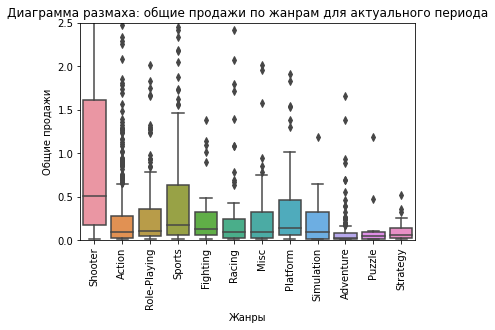

In [32]:
sns.boxplot(data = data_actual, x = 'genre', y = 'sales_total');
plt.ylim(0, 2.5)
plt.title ('Диаграмма размаха: общие продажи по жанрам для актуального периода')
plt.ylabel ('Общие продажи')
plt.xlabel ('Жанры')
plt.xticks(rotation=90);


Изучив данные о медианных продажах к самому прибыльному жанру можно отнести Shooter.

Жанр с минимальным значением медианной продажи - Adventure.

## Портрет пользователя каждого региона

### самые популярные платформы в Северной Америке (топ-5)

In [33]:
platforms_in_na = data_actual.pivot_table (index='platform', values='na_sales', aggfunc='sum'). sort_values(by='na_sales', ascending=False)
platforms_in_na.head()

,na_sales
platform,
PS4,98.61
XOne,81.27
X360,28.30
3DS,22.64
PS3,22.05


In [34]:
# объединим платформы, не вошедние в топ-5  в 'others' и посчитаем общую для них сумму продаж
platforms_in_na.loc['Other', 'na_sales'] = platforms_in_na.iloc[5:].sum()[0]
display(platforms_in_na)

,na_sales
platform,
PS4,98.61
XOne,81.27
X360,28.30
3DS,22.64
PS3,22.05
WiiU,19.36
PC,7.23
PSV,2.52
Wii,2.08


In [35]:
print(len(platforms_in_na))

11


In [36]:
# оставим с таблице только топ-5 и others
platforms_in_na = platforms_in_na.iloc [[0,1, 2, 3, 4, 10]]

In [37]:
display(platforms_in_na)

,na_sales
platform,
PS4,98.61
XOne,81.27
X360,28.30
3DS,22.64
PS3,22.05
Other,31.19


In [38]:
# посчитаем общую сумму продаж платформ по региону
platforms_in_na['na_sales']. sum ().round(0)

284.0

In [39]:
# определим процентное соотношение продаж топ-5 платформ и остальных к общим продажам по региону
platforms_in_na['percent_sales'] = (platforms_in_na['na_sales']/284.0*100).round(0)

In [40]:
display(platforms_in_na)

,na_sales,percent_sales
platform,,
PS4,98.61,35.0
XOne,81.27,29.0
X360,28.30,10.0
3DS,22.64,8.0
PS3,22.05,8.0
Other,31.19,11.0


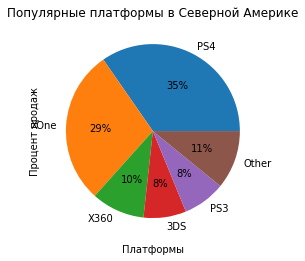

In [42]:
# визуализируем полученные данные
platforms_in_na.plot(kind='pie',y='percent_sales', legend=False, figsize=(4,4), autopct='%.0f%%')
plt.title ('Популярные платформы в Северной Америке')
plt.ylabel ('Процент продаж')
plt.xlabel ('Платформы');

### самые популярные платформы в Европе (топ-5)

In [43]:
platforms_in_eu = data_actual.pivot_table (index='platform', values='eu_sales', aggfunc='sum'). sort_values(by='eu_sales', ascending=False)
platforms_in_eu.head()

,eu_sales
platform,
PS4,130.04
XOne,46.25
PS3,25.54
PC,17.97
3DS,16.12


In [44]:
# объединяем платформы, не вошедние в топ-5  в 'others' и посчитаем общую для них сумму продаж
platforms_in_eu.loc['Other', 'eu_sales'] = platforms_in_eu.iloc[5:].sum()[0]
display(platforms_in_eu)

,eu_sales
platform,
PS4,130.04
XOne,46.25
PS3,25.54
PC,17.97
3DS,16.12
X360,15.49
WiiU,13.15
PSV,3.53
Wii,2.59


In [45]:
print(len(platforms_in_eu))

11


In [46]:
# оставим с таблице только топ-5 и others
platforms_in_eu = platforms_in_eu.iloc [[0,1, 2, 3, 4, 10]]
display(platforms_in_eu)

,eu_sales
platform,
PS4,130.04
XOne,46.25
PS3,25.54
PC,17.97
3DS,16.12
Other,34.76


In [47]:
# посчитаем общую сумму продаж платформ по региону
platforms_in_eu['eu_sales']. sum ().round(0)

271.0

In [48]:
# определим процентное соотношение продаж платформ к общим продажам по региону
platforms_in_eu['percent_sales'] = (platforms_in_eu['eu_sales']/271.0*100).round(0)

In [49]:
display(platforms_in_eu)

,eu_sales,percent_sales
platform,,
PS4,130.04,48.0
XOne,46.25,17.0
PS3,25.54,9.0
PC,17.97,7.0
3DS,16.12,6.0
Other,34.76,13.0


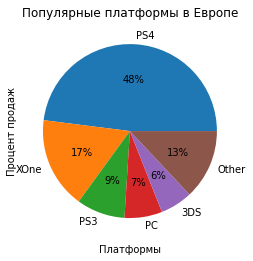

In [50]:
# визуализируем полученные данные
platforms_in_eu.plot(kind='pie',y='percent_sales', legend=False, figsize=(4,4), autopct='%.0f%%')
plt.title ('Популярные платформы в Европе')
plt.ylabel ('Процент продаж')
plt.xlabel ('Платформы');

### самые популярные платформы в Японии (топ-5)

In [51]:
platforms_in_jp = data_actual.pivot_table (index='platform', values='jp_sales', aggfunc='sum'). sort_values(by='jp_sales', ascending=False)
platforms_in_jp.head()

,jp_sales
platform,
3DS,44.24
PS4,15.02
PSV,14.54
PS3,11.22
WiiU,7.31


In [52]:
# объединяем платформы, не вошедние в топ-5  в 'others' и посчитаем общую для них сумму продаж
platforms_in_jp.loc['Other', 'jp_sales'] = platforms_in_jp.iloc[5:].sum()[0]
display(platforms_in_jp)

,jp_sales
platform,
3DS,44.24
PS4,15.02
PSV,14.54
PS3,11.22
WiiU,7.31
PSP,0.36
XOne,0.32
X360,0.08
PC,0.00


In [53]:
# оставим с таблице только топ-5 и others
platforms_in_jp = platforms_in_jp.iloc [[0,1, 2, 3, 4, 10]]
display(platforms_in_jp)

,jp_sales
platform,
3DS,44.24
PS4,15.02
PSV,14.54
PS3,11.22
WiiU,7.31
Other,0.76


In [54]:
# посчитаем общую сумму продаж платформ по региону
platforms_in_jp['jp_sales']. sum ().round(0)

93.0

In [55]:
# определим процентное соотношение продаж платформ к общим продажам по региону
platforms_in_jp['percent_sales'] = (platforms_in_jp['jp_sales']/93.0*100).round(0)

In [56]:
display(platforms_in_jp)

,jp_sales,percent_sales
platform,,
3DS,44.24,48.0
PS4,15.02,16.0
PSV,14.54,16.0
PS3,11.22,12.0
WiiU,7.31,8.0
Other,0.76,1.0


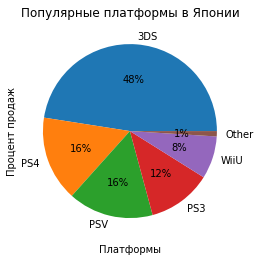

In [57]:
# визуализируем полученные данные
platforms_in_jp.plot(kind='pie',y='percent_sales', legend=False, figsize=(4,4), autopct='%.0f%%')
plt.title ('Популярные платформы в Японии')
plt.ylabel ('Процент продаж')
plt.xlabel ('Платформы');

Проанализировав популярность платформ для разных регионов, мы видим, что лидеры рынка отличаются. 
В каждом регионе лидируют разные платформы с заметным преобладанием:

в Северной Америке - PS4 (35%) и XOne (29%)

в Европе - PS3	(48%)

в Японии - 3DS (48%).

Также обращает внимание, что платформа PS3 входит в топ-5 популярных платформ во всех регионах.

Напротив, есть и те платформы, которые представлены не во всех регионах.
Например, XOne популярна в Северной Америке и в Европе, но при этом не попала в топ-5 популярных платформ в Японии. 


### самые популярные жанры в Северной Америке (топ-5)

In [58]:
genres_in_na = data_actual.pivot_table (index='genre', values='na_sales', aggfunc='sum'). sort_values(by='na_sales', ascending=False)
genres_in_na.head()

,na_sales
genre,
Shooter,79.02
Action,72.53
Sports,46.13
Role-Playing,33.47
Misc,15.05


### самые популярные жанры в Европе (топ-5)

In [59]:
genres_in_eu = data_actual.pivot_table (index='genre', values='eu_sales', aggfunc='sum'). sort_values(by='eu_sales', ascending=False)
genres_in_eu.head()

,eu_sales
genre,
Action,74.68
Shooter,65.52
Sports,45.73
Role-Playing,28.17
Racing,14.13


### самые популярные жанры в Японии (топ-5)

In [60]:
genres_in_jp = data_actual.pivot_table (index='genre', values='jp_sales', aggfunc='sum'). sort_values(by='jp_sales', ascending=False)
genres_in_jp.head()

,jp_sales
genre,
Role-Playing,31.16
Action,29.58
Fighting,6.37
Misc,5.61
Shooter,4.87


Обращает внимание, что в Северной Америке и Европе, в основном, популярны одни и те же жанры, в то время как в Японии популярность жанров распределена иначе. 

## Влияние рейтинга ESRB на продажи в отдельном регионе

In [61]:
rating_in_na = data_actual.pivot_table (index='rating', values='na_sales', aggfunc='sum'). sort_values(by='na_sales', ascending=False)
display(rating_in_na)

,na_sales
rating,
M,96.42
Unknown,64.72
E,50.74
T,38.95
E10+,33.23


In [62]:
rating_in_eu = data_actual.pivot_table (index='rating', values='eu_sales', aggfunc='sum'). sort_values(by='eu_sales', ascending=False)
display(rating_in_eu)

,eu_sales
rating,
M,93.44
Unknown,58.95
E,58.06
T,34.07
E10+,26.16


In [63]:
rating_in_jp = data_actual.pivot_table (index='rating', values='jp_sales', aggfunc='sum'). sort_values(by='jp_sales', ascending=False)
display(rating_in_jp)

,jp_sales
rating,
Unknown,56.90
T,14.78
E,8.94
M,8.01
E10+,4.46


При оценке влияния рейтинга ESRB на общие продажи выявлено, что данные сильно отличаются по регионам. 

Например, в Японии большая часть проданных игр не имеет маркировку ESRB. Возможно, это связано с тем, что маркировка игр в данном регионе не обязательна и проводится не всегда. 

В Европе и Северной Америке большая часть проданных игр имеет маркировку M (подходит для игроков 17 и страше лет).

## Проверка гипотез

Формулировака гипотезы

H0- средние пользовательские рейтинги платформ Xbox One и PC равны

H1- средние пользовательские рейтинги платформ Xbox One и PC не равны

In [64]:
sample_1 = data_actual.loc[(data_actual['platform'] == 'XOne') & ~data_actual['user_score'].isnull()]['user_score']
                           
sample_2 = data_actual.loc[(data_actual['platform'] == 'PC') & ~data_actual['user_score'].isnull()]['user_score']
alpha = 0.05 # уровень статистической значимости
# если p-value окажется меньше него, отвергнем гипотезу

results = st.ttest_ind(sample_1, sample_2)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 0.10450507919348415
Не получилось отвергнуть нулевую гипотезу


Средние пользовательские рейтинги жанров Action и Sports разные.

H0- средние пользовательские рейтинги жанров Action  и Sports равны.

H1- средние пользовательские рейтинги жанров Action  и Sports не равны.

In [65]:
sample_1 = data_actual.loc[(data_actual['genre'] == 'Action') & ~data_actual['user_score'].isnull()]['user_score']
                           
sample_2 = data_actual.loc[(data_actual['genre'] == 'Sports') & ~data_actual['user_score'].isnull()]['user_score']

alpha = 0.05 # уровень статистической значимости
# если p-value окажется меньше него, отвергнем гипотезу

results = st.ttest_ind(sample_1, sample_2)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 2.8711147985105864e-19
Отвергаем нулевую гипотезу


## ВЫВОД 

###  Цель исследования:

Выявить закономерности, влияющие на успешность игр. Определить потенциально успешный продукт, на основании чего дать рекомендации о проведении рекламных команий.

### Ход исследования:

#### Этап предобработки данных

На этапе предобработки данных были выявлены и обработаны пропуски, внесены новые данные об общих продажах, названия столбцов приведены к нижнему регистру. 


#### Исследовательский анализ данных

В ходе исследовательского анализа данных выявлено, что после 2000 года количество выпускавшихся игр значительно больше, чем до,  с пиковыми значениями 2008-2010 гг.

В среднем, одна платформа активна в течение 5-10 лет. 

Для  исследования принятно решение определить актуальный период как период с 2014 по 2016 гг. 

Изучив данные за актуальный период мы видим, что платформы с наибольшими общими продажами в начале изучаемого периода (Wii, X360, PS3) к 2016 году становятся практически не актуальны. 

К потенциально прибыльным платформам можно отнести PS4 и XOne.

После изучения данных о медианных продажах выявлено, что  лидируют платформы X360, PS4, XOne, WiiU, Wii.

Изучив данные о корреляции между оценками критиков и игроков и общими продажами для одной из платформ (PS3) выяснили, что значимой зависимости между оценками и продажами нет, однако на общие продажи оценки критиков влияют больше, чем оценки игроков. 




#### Составление портрета пользователей каждого региона

Проанализировав популярность платформ для разных регионов, мы видим, что лидеры рынка отличаются. 
В каждом регионе лидируют разные платформы с заметным преобладанием:

в Северной Америке - PS4 (35%) и XOne (29%)

в Европе - PS3	(48%)

в Японии - 3DS (48%).

Также обращает внимание, что платформа PS3 входит в топ-5 популярных платформ во всех регионах.

Напротив, есть и те платформы, которые представлены не во всех регионах.
Например, XOne популярна в Северной Америке и в Европе, но при этом не попала в топ-5 популярных платформ в Японии. 

Обращает внимание, что в Северной Америке и Европе, в основном, популярны одни и те же жанры, в то время как в Японии популярность жанров распределена иначе. 


При оценке влияния рейтинга ESRB на общие продажи выявлено, что данные сильно отличаются по регионам. 

Например, в Японии большая часть проданных игр не имеет маркировку ESRB. Возможно, это связано с тем, что маркировка игр в данном регионе не обязательна и проводится не всегда. 

В Европе и Северной Америке большая часть проданных игр имеет маркировку M (подходит для игроков 17 и страше лет).


#### Проверка гипотез
В ходе статистического анализа данных были получены следующие данные:

Cредние пользовательские рейтинги платформ Xbox One и PC равны.

Средние пользовательские рейтинги жанров Action и Sports не равны.



### Рекомендации: 

При разработке продукта и проведении рекламных компаний необходимо обратить внимание на регион, в котором они проводятся.

В США и Европе наиболее популярны жанры Action и Shooter, в то время как в Японии более популярны Role-Playing и Action.

К потенциально прибыльным платформам можно отнести PS4 и XOne.
